In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import torch.nn.functional as F
import torch.nn as nn
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader, Dataset
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import random
import torch.utils.data as data
import torch.nn.init as init
from torch.optim.lr_scheduler import StepLR
from tabulate import tabulate
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset, DataLoader

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.layer1(x) + x
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        x = F.relu(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [5]:
model = ResNet18().to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [6]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [7]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor(), download=True)
#train_dataset = datasets.EuroSAT(root='data/', transform=transforms.ToTensor(), download=True)
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
def create_validationset(trainset, batch_size=64):
  # Define the indices for the train and validation sets
  '''
  train_indices = list(range(len(trainset)))
  train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices[:45000])
  val_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices[45000:])

  # Create the train and validation datasets
  trainset1 = Subset(trainset, train_indices[:45000])
  valset = Subset(trainset, train_indices[45000:])
  '''
  # Define the indices for training and validation sets
  n_train = len(train_dataset)
  train_idx = list(range(n_train))
  val_size = 0.2
  val_count = int(val_size * n_train)
  val_idx = torch.randperm(n_train)[:val_count]
  train_idx = list(set(train_idx) - set(val_idx))

  # Define samplers for the train and validation sets
  train_sampler = SubsetRandomSampler(train_idx)
  val_sampler = SubsetRandomSampler(val_idx)

  # Set up the data loaders for the train and validation datasets
  trainloader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
  valloader = DataLoader(trainset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

  return trainloader,valloader

In [9]:
train_loader, val_loader = create_validationset(train_loader.dataset)

In [10]:
def split_train(trainset, num_labeled=1000, num_classes=10):

  num_per_class = int(num_labeled / num_classes)  # number of labeled data points per class

  labeled_indices = []
  unlabeled_indices = []

  for i in range(num_classes):
      indices = np.where(np.array(trainset.targets) == i)[0]
      np.random.shuffle(indices)
      labeled_indices.extend(indices[:num_per_class])
      unlabeled_indices.extend(indices[num_per_class:num_per_class+num_per_class//2])

  # Create data loaders for labeled and unlabeled data
  labeled_sampler = torch.utils.data.sampler.SubsetRandomSampler(labeled_indices)
  unlabeled_sampler = torch.utils.data.sampler.SubsetRandomSampler(unlabeled_indices)

  labeled_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=labeled_sampler)
  unlabeled_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=unlabeled_sampler)

  torch.save({
      'labeled_loader': labeled_loader,
      'unlabeled_loader': unlabeled_loader
  }, "content/Labeled1/SplittedLoaders.pt")

  return labeled_loader, unlabeled_loader


In [11]:
labeled_loader, unlabeled_loader = split_train(train_loader.dataset)

In [12]:
def weight_init(m):
  if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
    init.xavier_uniform_(m.weight.data)  # initialize weights using Xavier uniform
    if m.bias is not None:
      init.constant_(m.bias.data, 0.0)  # initialize biases to 0

In [13]:

def validation(val_loader, model, criterion):
  # Evaluate the model on the validation set
  with torch.no_grad():
    val_loss = 0.0
    correct = 0
    total = 0
    for batch in val_loader:
      inputs, labels = batch
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      val_loss += criterion(outputs, labels).item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

    return val_loss,accuracy


In [14]:

def validation_binary(val_loader, model, criterion):

  with torch.no_grad():
    val_loss = 0.0
    correct = 0
    total = 0
    for j, (inputs, labels) in enumerate(val_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      val_loss += criterion(outputs, labels).item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

    return val_loss,accuracy


In [15]:
def train(trainloader,model, num_epochs,val_loader):
  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  allEpochs=[]
  allLoss=[]
  allval = []

  # Set the model to training mode
  model.train()

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0.0

    for i, (images, labels) in enumerate(trainloader):
      # Send the images and labels to the device
      images = images.to(device)
      labels = labels.to(device)

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward pass and optimization
      loss.backward()
      optimizer.step()

      # Update the running loss
      running_loss += loss.item() * images.size(0)

    val_loss, val_acc = validation(val_loader, model,criterion)

    # Print the average training loss for the epoch
    epoch_loss = running_loss / len(trainloader.dataset)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Additional information
    EPOCH = epoch
    PATH = "content/Labeled1/Newfulldatamodel.pt"
    Path_el = "content/Labeled1/NewfulldatamodelEpochsandLoss.pt"
    LOSS = loss.item()
    allEpochs.append(EPOCH)
    allLoss.append(LOSS)
    allval.append(val_loss)

    torch.save({
        'epoch': EPOCH,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': LOSS,
        'val_loss': allval,
        'val_acc': val_acc,
        'outputs': outputs,
        'seed': torch.seed()
        }, PATH)

    torch.save({
          'epoch': allEpochs,
          'loss': allLoss,
          'val_loss': allval,
          'val_acc': val_acc
          }, Path_el)


  return model,allEpochs,allLoss,allval

In [16]:
def train_binary(trainloader,model, num_epochs, b, val_loader):
  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  allEpochs=[]
  allLoss=[]
  allval = []

  # Set the model to training mode
  model.train()

  # Train the model
  for epoch in range(num_epochs):  # replace with the desired number of epochs
      running_loss = 0.0
      for i, (images, labels) in enumerate(trainloader):

        # Send the images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item() * images.size(0)
      val_loss, val_acc = validation_binary(val_loader,model,criterion)

      # Print the average training loss for the epoch
      epoch_loss = running_loss / len(trainloader.dataset)
      print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

      # Additional information
      EPOCH = epoch
      PATH = "content/Labeled1/Newbinarydatamodel" + str(b) + ".pt"
      Path_el = "content/Labeled1/NewbinarydatamodelEpochsandLoss" + str(b) + ".pt"

      LOSS = loss.item()
      allEpochs.append(EPOCH)
      allLoss.append(LOSS)
      allval.append(val_loss)

      torch.save({
          'epoch': EPOCH,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': LOSS,
          'val_loss': val_loss,
          'val_accuracy': val_acc,
          'outputs': outputs,
          'class_num': b,
          'seed': torch.seed()
          }, PATH)

      torch.save({
          'epoch': allEpochs,
          'loss': allLoss,
          'val_loss': allval,
          'val_accuracy': val_acc,
          'class_num': b
          }, Path_el)


  # Save the trained model
  #torch.save(model.state_dict(), 'binary_classifier.pt')
  return model, allEpochs, allLoss, allval

In [17]:
def test(model, test_loader):
  Path_acc = "content/Labeled1/Fullaccuracy.pt"

  model.eval()
  # Evaluate the model
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

    torch.save({
          'epoch': accuracy
          }, Path_acc)

    return accuracy


In [18]:
def test_binary(model, test_loader,b):
  Path_acc = "content/Labeled1/Binaryaccuracy" + str(b) + ".pt"
  model.eval()
  # Evaluate the model
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images[0].to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      #print(predicted)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    torch.save({
          'epoch': accuracy
          }, Path_acc)
    return accuracy


In [19]:
def load_model_binary():
  ch = torch.load("content/Labeled1/Newfulldatamodel.pt", device)
  model1 = ResNet18().to(device)
  model1.load_state_dict(ch['model_state_dict'])
  model1.eval()
  in_features = model1.fc.in_features  # get number of input features of last layer
  model1.fc = nn.Linear(in_features, 2)

  return model1

In [20]:
def freeze_layers(model1):
  # Freeze first 5 convolutional layers
  for param in model1.conv1.parameters():
      param.requires_grad = False
  for param in model1.layer1.parameters():
      param.requires_grad = False
  for param in model1.layer2.parameters():
      param.requires_grad = False
  for param in model1.layer3.parameters():
      param.requires_grad = False
  for param in model1.layer4.parameters():
      param.requires_grad = False


In [21]:
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

    def __len__(self):
        return len(self.data)


In [22]:
def getbinaryloader(loader, reqlabel):
  dataset = loader.dataset
  # Initialize lists for positive and negative samples
  positive_samples = []
  negative_samples = []
  positive_samples_targets = []
  negative_samples_targets = []
  data_pos = []
  data_neg = []
  print("initial")

  # Iterate over the dataset and separate the samples for each class
  for i in range(len(dataset)):
      sample, target = dataset[i]
      if target == reqlabel:
          positive_samples.append(i)
          data_pos.append(sample)
      else:
          negative_samples.append(i)
          data_neg.append(sample)

  print("After For")

  num_samples_pos = len(positive_samples)
  num_samples_neg = len(negative_samples)

  # Create a list of targets for the selected samples
  selected_targets = [1]*num_samples_pos + [0]*num_samples_neg
  selected_data = data_pos + data_neg

  del data_pos
  del data_neg

  print("Creating dataset")
  selected_dataset = MyDataset(selected_data, selected_targets)

  # Create a new dataloader with the selected and shuffled samples
  batch_size = 64
  dataloader = data.DataLoader(selected_dataset, batch_size=batch_size, shuffle=True)
  del selected_dataset

  return dataloader


In [23]:
def train_full(train_loader, val_loader, num_epochs):
  model = ResNet18().to(device)
  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  #scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
  model.apply(weight_init)
  print("Training")
  model_tr,epoc,trloss,valloss = train(train_loader, model, num_epochs, val_loader)

  return model

In [24]:
def train_binary_call(num, train_loader,vl,nepochs):
  dl0 = getbinaryloader(train_loader,num)
  val_loader1 = getbinaryloader(vl,num)
  criterion = nn.CrossEntropyLoss()
  model1 = load_model_binary().to(device)
  optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
  #scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
  model1.apply(weight_init)
  freeze_layers(model1)
  md_trained,epoc,trloss,valloss = train_binary(dl0, model1,nepochs,num,val_loader1)

  return md_trained


In [25]:
def predict_pseudolabels(testloader, model):

  # Evaluate the model on the test set
  model.eval()  # Set the model to evaluation mode
  prob = []
  indices_to_remove = []
  data = testloader.dataset
  print("loader: ", len(data))
  with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(testloader):
      # Forward pass and compute loss
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      outputs = torch.sigmoid(outputs)

      a,predicted = torch.max(outputs.data, dim=1)

      for i in range(len(predicted)):
        if a[i] >= 0.9:
          indices_to_remove.append(batch_idx * testloader.batch_size + i)
          prob.append(a[i])
  print("Indices: ", len(indices_to_remove))
      # Remove data from the dataset
  # create a subset of the dataset with some data removed
  after_remove_unlabeled = Subset(data, [i for i in range(len(data)) if i not in indices_to_remove])
  labeled_to_train = Subset(data, indices_to_remove)

  return labeled_to_train, after_remove_unlabeled


In [26]:
def getdataloaders(labeled_data, unlabeled_data, new_dataset,i):

  # append the new dataset to the existing dataset
  new_dataset.targets = [i]*len(new_dataset)
  full_dataset = ConcatDataset([labeled_data, new_dataset])

  # Create a new dataloader with the selected and shuffled samples
  batch_size = 64
  #indices = list(range(len(full_dataset)))
  #sampler = SubsetRandomSampler(indices)
  dataloader_full = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)
  dataloader_unlabeled = DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True)

  del full_dataset

  return dataloader_full,dataloader_unlabeled


In [27]:
def sortmodels():
  # Define a list to store the models and their validation accuracy
  models = []

  # Loop over the models and compute validation accuracy for each one
  for i in range(10):
      ch = torch.load("content/Labeled1/Newbinarydatamodel9" + ".pt",device)
      model1 = ResNet18(num_classes=2).to(device)
      model1.load_state_dict(ch["model_state_dict"])
      model1.eval()
      print(ch.keys())
      acc = ch["val_accuracy"]
      models.append({'model': model1, 'accuracy': acc, 'classifier': i})

  # Sort the models based on validation accuracy in descending order
  models.sort(key=lambda x: x['accuracy'], reverse=True)

  # Print the sorted list of models and their validation accuracy
  for model in models:
      print(f"Model: {model['model']} Validation Accuracy: {model['accuracy']} classifier: {model['classifier']}")

  return models


In [60]:
modelf = train_full(labeled_loader, val_loader,100)

Training
Validation Accuracy: 56.02%
Epoch 1/100, Training Loss: 0.0349, Validation Loss: 0.2518
Validation Accuracy: 80.31%
Epoch 2/100, Training Loss: 0.0136, Validation Loss: 0.1319
Validation Accuracy: 87.53%
Epoch 3/100, Training Loss: 0.0062, Validation Loss: 0.0846
Validation Accuracy: 91.86%
Epoch 4/100, Training Loss: 0.0038, Validation Loss: 0.0557
Validation Accuracy: 91.63%
Epoch 5/100, Training Loss: 0.0021, Validation Loss: 0.0557
Validation Accuracy: 92.50%
Epoch 6/100, Training Loss: 0.0021, Validation Loss: 0.0510
Validation Accuracy: 92.65%
Epoch 7/100, Training Loss: 0.0017, Validation Loss: 0.0527
Validation Accuracy: 93.78%
Epoch 8/100, Training Loss: 0.0010, Validation Loss: 0.0445
Validation Accuracy: 94.20%
Epoch 9/100, Training Loss: 0.0008, Validation Loss: 0.0419
Validation Accuracy: 94.77%
Epoch 10/100, Training Loss: 0.0007, Validation Loss: 0.0390
Validation Accuracy: 95.03%
Epoch 11/100, Training Loss: 0.0006, Validation Loss: 0.0363
Validation Accuracy: 

Bad pipe message: %s [b'\xf6\xb9\x8e\x88\xea\x91\xa0G\xa1=\xd2\xc2=\xf3\xea?QW\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00', b"\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\xc0\x17\xc0\x18\xc0\x19\xc0#\xc0$\xc0%\xc0&\

Validation Accuracy: 96.24%
Epoch 99/100, Training Loss: 0.0000, Validation Loss: 0.0364
Validation Accuracy: 96.51%
Epoch 100/100, Training Loss: 0.0000, Validation Loss: 0.0355


In [62]:
for i in range(9,10):
  modelb = train_binary_call(i,labeled_loader, val_loader,100)
  print("Classifier Completed: " + str(i))

initial
After For
Creating dataset
initial
After For
Creating dataset


/var/folders/mf/6c6r69vs6xb7_882kknxt6wh0000gs/T/ipykernel_59583/722626161.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ch = torch.load("content/Labeled1/Newfulldatam

Validation Accuracy: 94.99%
Epoch 1/100, Training Loss: 0.2062, Validation Loss: 0.1422
Validation Accuracy: 94.51%
Epoch 2/100, Training Loss: 0.1438, Validation Loss: 0.1478
Validation Accuracy: 96.10%
Epoch 3/100, Training Loss: 0.1319, Validation Loss: 0.1094
Validation Accuracy: 96.02%
Epoch 4/100, Training Loss: 0.1305, Validation Loss: 0.1119
Validation Accuracy: 96.20%
Epoch 5/100, Training Loss: 0.1241, Validation Loss: 0.1070
Validation Accuracy: 96.20%
Epoch 6/100, Training Loss: 0.1231, Validation Loss: 0.1104
Validation Accuracy: 96.68%
Epoch 7/100, Training Loss: 0.1187, Validation Loss: 0.0964
Validation Accuracy: 92.36%
Epoch 8/100, Training Loss: 0.1122, Validation Loss: 0.1873
Validation Accuracy: 96.67%
Epoch 9/100, Training Loss: 0.1120, Validation Loss: 0.0942
Validation Accuracy: 96.14%
Epoch 10/100, Training Loss: 0.1076, Validation Loss: 0.1149
Validation Accuracy: 96.81%
Epoch 11/100, Training Loss: 0.1066, Validation Loss: 0.0914
Validation Accuracy: 96.75%
Ep

Bad pipe message: %s [b'\x18\xa0)<\x87=\xdf\xba\xfa\xb4\x9aF\x05H\xb0o7\xd0\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C']
Bad pipe message: %s [b'\xa7\x98\x1a1\xf3\xa3\x86\x83,\xc9\xf9\x884b\x94\x04\xd9\x0f\x00\x01|\x00\x00\x00\x01\x00']
Bad pipe message: %s [b'\x89\xbbm"R`\x94\xb5\xb3\x16Z\xb6\xc4:<\x92g\x00\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00']
Bad pipe message: %s [b'/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00']
Bad pipe message: %s [b'\x03']
Bad pipe message: %s [b'=\x00>\x00?\x00@\x00A\x00B\x0

Validation Accuracy: 96.89%
Epoch 83/100, Training Loss: 0.0948, Validation Loss: 0.0863
Validation Accuracy: 95.84%
Epoch 84/100, Training Loss: 0.0977, Validation Loss: 0.1378
Validation Accuracy: 97.08%
Epoch 85/100, Training Loss: 0.0957, Validation Loss: 0.0801
Validation Accuracy: 97.35%
Epoch 86/100, Training Loss: 0.0971, Validation Loss: 0.0763
Validation Accuracy: 97.37%
Epoch 87/100, Training Loss: 0.0934, Validation Loss: 0.0773
Validation Accuracy: 97.32%
Epoch 88/100, Training Loss: 0.0979, Validation Loss: 0.0854
Validation Accuracy: 97.08%
Epoch 89/100, Training Loss: 0.0963, Validation Loss: 0.0818
Validation Accuracy: 97.26%
Epoch 90/100, Training Loss: 0.0943, Validation Loss: 0.0785
Validation Accuracy: 97.33%
Epoch 91/100, Training Loss: 0.0947, Validation Loss: 0.0785
Validation Accuracy: 93.90%
Epoch 92/100, Training Loss: 0.0913, Validation Loss: 0.2307
Validation Accuracy: 97.24%
Epoch 93/100, Training Loss: 0.0971, Validation Loss: 0.0849
Validation Accuracy: 

In [28]:
PATH = "content/Labeled1/Newfulldatamodel.pt"
chh = torch.load(PATH)
modelq = ResNet18().to(device)
modelq.load_state_dict(chh["model_state_dict"])
modelq.eval()
a = test(modelq, test_loader)
a

/var/folders/mf/6c6r69vs6xb7_882kknxt6wh0000gs/T/ipykernel_2169/259134756.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chh = torch.load(PATH)


Accuracy: 93.64%


93.64

In [29]:
allacc = []
test_loader1 = unlabeled_loader
print("Initial loader1", len(test_loader1)*64)
for i in range(6):
  ch = torch.load("content/Labeled1/Newbinarydatamodel9" + ".pt",device)
  model1 = ResNet18(num_classes=2).to(device)
  model1.load_state_dict(ch["model_state_dict"])
  model1.eval()
  dlt = getbinaryloader(test_loader1,i)
  lt,ul = predict_pseudolabels(dlt, model1)
  lbl_tr, unlbld = getdataloaders(train_loader.dataset, ul, lt, i)
  test_loader1 = unlbld
  print("Remaining unlabeled data after model : " + str(i), len(ul))
  print("Training after" + str(i), len(lbl_tr))

Initial loader1 512
initial


/var/folders/mf/6c6r69vs6xb7_882kknxt6wh0000gs/T/ipykernel_2169/4064888636.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ch = torch.load("content/Labeled1/Newbinarydat

After For
Creating dataset
loader:  60000
Indices:  48893
Remaining unlabeled data after model : 0 11107
Training after0 1702
initial
After For
Creating dataset
loader:  11107
Indices:  9015
Remaining unlabeled data after model : 1 2092
Training after1 1079
initial
After For
Creating dataset
loader:  2092
Indices:  1677
Remaining unlabeled data after model : 2 415
Training after2 964
initial
After For
Creating dataset
loader:  415
Indices:  339
Remaining unlabeled data after model : 3 76
Training after3 943
initial
After For
Creating dataset
loader:  76
Indices:  59
Remaining unlabeled data after model : 4 17
Training after4 939
initial
After For
Creating dataset
loader:  17
Indices:  14
Remaining unlabeled data after model : 5 3
Training after5 938


In [ ]:
allacc = []
test_loader1 = unlabeled_loader
models = sortmodels()
print("Initial loader1", len(test_loader1)*64)
i=0
for i in range(6):

  dlt = getbinaryloader(test_loader1,i)
  lbtotrain,ulleft = predict_pseudolabels(dlt,models[i]['model'])
  lbl_tr, unlbld = getdataloaders(labeled_loader.dataset, ulleft, lbtotrain,i)
  test_loader1 = unlbld
  print("Remaining unlabeled data after model : " + str(i), len(ul))
  print("Training after" + str(i), len(lbl_tr))

  torch.save({
      'unlabeled': len(ulleft),
      'labeled': len(lbl_tr)
  }, "content/Labeled1/num_samples_c" + str(i) + ".pt")

/var/folders/mf/6c6r69vs6xb7_882kknxt6wh0000gs/T/ipykernel_10214/3611112832.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ch = torch.load("content/Labeled1/Newbinaryda

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss', 'val_loss', 'val_accuracy', 'outputs', 'class_num', 'seed'])
dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss', 'val_loss', 'val_accuracy', 'outputs', 'class_num', 'seed'])
dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss', 'val_loss', 'val_accuracy', 'outputs', 'class_num', 'seed'])
dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss', 'val_loss', 'val_accuracy', 'outputs', 'class_num', 'seed'])
dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss', 'val_loss', 'val_accuracy', 'outputs', 'class_num', 'seed'])
dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss', 'val_loss', 'val_accuracy', 'outputs', 'class_num', 'seed'])
dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss', 'val_loss', 'val_accuracy', 'outputs', 'class_num', 'seed'])
dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss

# Plot Loss and Accuracy

/var/folders/mf/6c6r69vs6xb7_882kknxt6wh0000gs/T/ipykernel_2169/1136612718.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PATH)


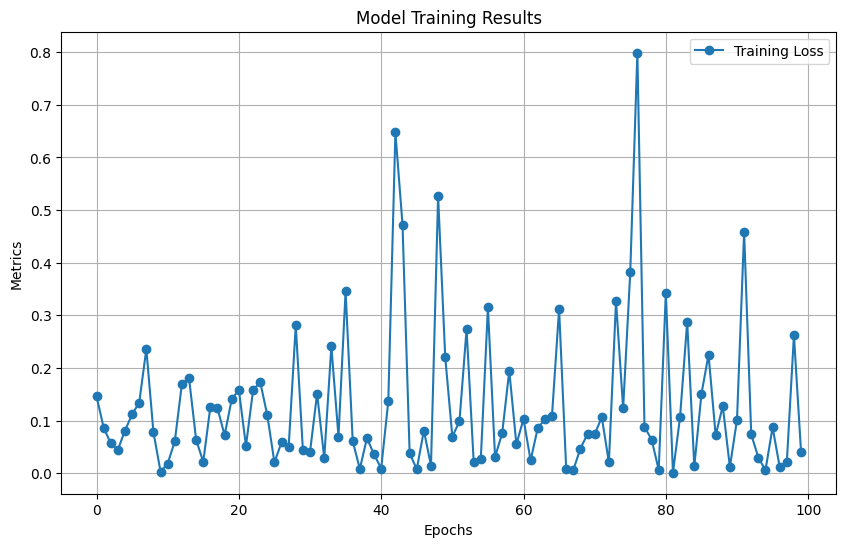

In [55]:
import torch
import matplotlib.pyplot as plt

# Load the .pt file
PATH = "content/Labeled1/NewbinarydatamodelEpochsandLoss9.pt"  # Adjust path as needed
checkpoint = torch.load(PATH)

# Extract saved data
epochs = checkpoint.get('epoch', [])  # Number of epochs
loss = checkpoint.get('loss', [])  # Training loss

# Check if data is valid
if not isinstance(epochs, list):
    epochs = list(range(1, len(loss) + 1))  # Generate epoch numbers if not stored

# Plot results
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(epochs, loss, label='Training Loss', marker='o')

# Customize the plot
plt.title("Model Training Results")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


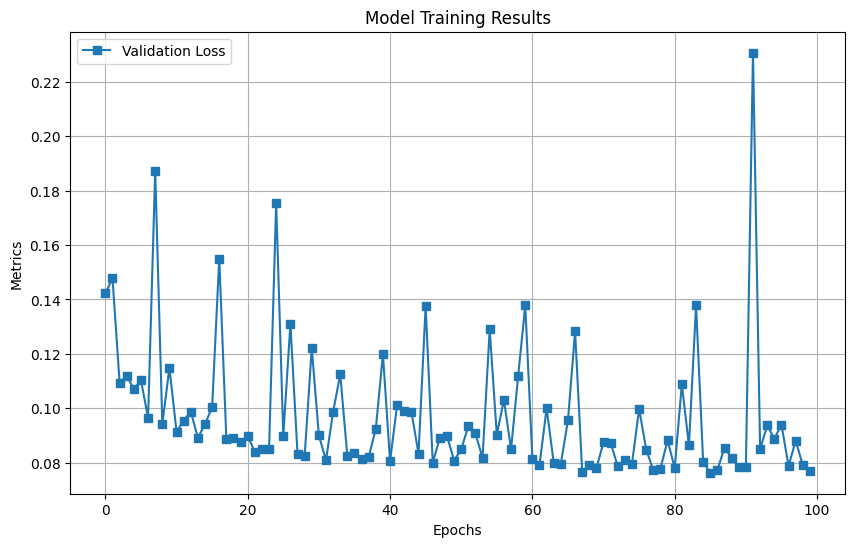

In [57]:
val_loss = checkpoint.get('val_loss', [])  # Validation loss

# Check if data is valid
if not isinstance(epochs, list):
    epochs = list(range(1, len(val_loss) + 1))  # Generate epoch numbers if not stored

# Plot results
plt.figure(figsize=(10, 6))

# Plot validation loss
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')

# Customize the plot
plt.title("Model Training Results")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
